#### Minko KB. ITF. MPEI. Version 0.5 - August 2025

# Пример программы для решения одномерного уравнения переноса (диффузии) (Часть 2, КМ)

## Постановка задачи
В качестве базовой мы рассмотрим задачу о передаче тепла через плоскую стенку. Внутри стенки существует внутреннее тепловыделение, например, за счет протекания тока. На правой и левой границах плоской стенки заданы постоянные значения температуры. Теплопроводность стенки постоянна и изотропна. Схема представлена на рисунке:

![Title](./fig/fig.png)

Дано: $\lambda$ = 0.1 Вт/(м$^0$C), $T_{A}$ = 0 $^0$C, $T_{B}$ = 50 $^0$C, $q_{V}$ = 1.0 МВт/м$^3$, $L_{x}$ = 10$^{-2}$ м

## Создание сетки
Первый шаг - **дискретизация** геометрии, т.е. замена непрерывно изменяющейся координаты $x$ набором точек $x_{i}$. Импортируем все необходимые нам библиотеки, в том числе и библиотеку **matplotlib**, которая позволит представить результаты расчетов более наглядно.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Наиболее простой сеткой является равномерная сетка. Как правило, в реальных задачах равномерная сетка не является оптимальным выбором, но для учебных целей она служит идеальным кандидатом и позволяет сосредоточиться на ключевых моментах и избежать второстепенных деталей. Для создания одномерной равномерной сетки необходимо задать два параметра: длину расчетной области $L_{x}$ и количество контрольных объемов $N_{x}$

In [2]:
Lx = 0.01 #длина расчетной области
Nx = 5 #количество контрольных объемов
dx = Lx/Nx  #расстояние между центрами контрольных объемов
Area = 1.0 #Площадь всех граней (в многомерной задаче произведение dy на dz)

Зная указанные параметры, создадим массив XFace, содержащий координаты всех граней. Для этого используем функцию [linspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html), которая размещает на отрезке заданное количество равномерно расположенных точек. По умолчанию концы отрезка также входят в число данных точек. Следует учесть, что количество граней контрольных объемов больше общего количества контрольных объемов на единицу.

In [3]:
XFace = np.linspace(0.0,Lx,Nx+1)
XFace

array([0.   , 0.002, 0.004, 0.006, 0.008, 0.01 ])

В общем случае ширину КО dx можно рассчитать, как разность координат граней.

In [4]:
DX = XFace[1:Nx+1] - XFace[0:Nx]
DX

array([0.002, 0.002, 0.002, 0.002, 0.002])

Создадим массив, который будет содержать площади всех граней, в нашем случае их значения постоянны.

In [5]:
#Площади граней
AFace = np.zeros(Nx+1)
AFace[:] = Area
AFace

array([1., 1., 1., 1., 1., 1.])

Далее мы должны найти координаты центров всех контрольных объемов. Для этого нужно определить кординаты точек, расположенных в середине граней. Данную операцию можно сделать двумя способами: реализовать в виде цикла **for** или в матричном виде. В виде цикла данная процедура будет выглядеть следующим образом:

In [6]:
#Создаем массив XP с размером Nx и инициализируем его нулевыми значениями .  
XP = np.zeros(Nx)
#Заполняем массив XP значением x координаты центра граней.
for i in range(Nx):
    XP[i] = (XFace[i]+XFace[i+1])/2.0
XP

array([0.001, 0.003, 0.005, 0.007, 0.009])

Второй споcоб - это использование срезов массивов, доступных благодаря библиотеке NumPy:

In [7]:
XFace[0:Nx] #координаты левых граней, т.е. все грани за исклчением самой правой

array([0.   , 0.002, 0.004, 0.006, 0.008])

In [8]:
XFace[1:Nx+1] #координаты правых граней, т.е. все грани за исклчением самой левой

array([0.002, 0.004, 0.006, 0.008, 0.01 ])

In [9]:
XP = (XFace[0:Nx] + XFace[1:Nx+1])/2.0

In [10]:
XP

array([0.001, 0.003, 0.005, 0.007, 0.009])

Объясним данный способ детальнее. Команда XFace[0:Nx] создает срез массива, состоящий из $XFace_{i}$, где $i=0,\ N_{x}-1$. Команда XFace[1:Nx+1] создает срез массива, состоящий из $XFace_{i}$, где $i=1,\ N_{x}$. В итоге получаются два массива размером $N_{x}$, и сложение этих массивов и дает нужную нам сумму.

Найдем значения объемов, занимаемых контрольным объемами (формула для определения площади трапеции):

Массив со значениями величины $\Phi$ в центрах контрольных объемов (расчет данного столбца и является целью рассчета)

In [11]:
Phi = np.zeros_like(XP)
Phi

array([0., 0., 0., 0., 0.])

In [12]:
#объемы КО
VolumeP = np.zeros(Nx)
VolumeP[:] = DX[0:Nx]*(AFace[0:Nx] + AFace[1:Nx+1])/2.0
VolumeP

array([0.002, 0.002, 0.002, 0.002, 0.002])

Для наглядности визуализируем построенную нами сетку и подпишем номера граней и контрольных объемов. Для контрольного объема номер два показана система обозначений, принятая нами при выводе дискретного аналога задачи.

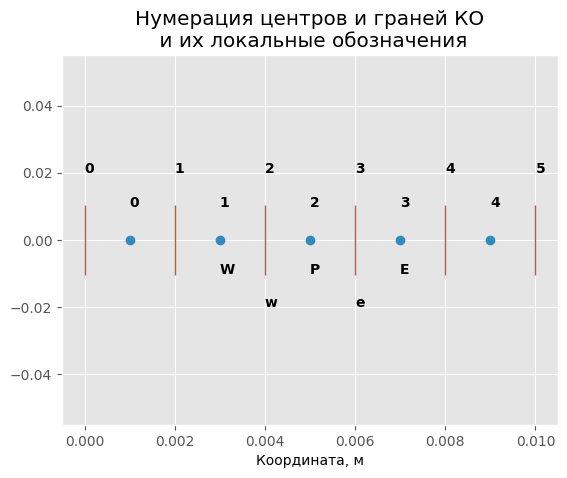

In [13]:
plt.plot(XFace,np.zeros_like(XFace),'|',markersize =50)
plt.plot(XP,np.zeros_like(XP),'o')
for i in range(Nx):
    plt.text(XP[i],0.01,i,fontweight='bold')
i = 2
plt.text(XP[i],-0.01,'P',fontweight='bold')
plt.text(XP[i-1],-0.01,'W',fontweight='bold')
plt.text(XP[i+1],-0.01,'E',fontweight='bold')
for j in range(Nx+1):
    plt.text(XFace[j],0.02,j,fontweight='bold')
j = i
plt.text(XFace[i],-0.02,'w',fontweight='bold')
plt.text(XFace[i+1],-0.02,'e',fontweight='bold')
plt.xlabel("Координата, м")
plt.title("Нумерация центров и граней КО\n и их локальные обозначения")
plt.show()

## Расчет коэффициентов дискретного аналога
Следующий шаг - это расчет коэффициентов дискретного аналога обобщенного уравнения диффузии. Зададим теплопроводность материала, источник внутреннего тепловыделения, температуру правой и левой границ, а также рассчитаем расстояние между центрами контрольных объемов (для равномерной сетки):

In [14]:
Lambda = 0.1 #теплопроводность Вт/(м*К)
qv = 1.0e6    #внутреннее тепловыделение Вт/м^3
TA = 0.0 #температура слева
TB = 50.0 #температура справа

Создадим массив свойств. Свойства в общем виде могут зависеть от коордианты и самой неизвестной величины

In [15]:
def calcGamma(XP,PhiP):
    return Lambda

In [16]:
#Массив с обобщенным коэффициентом диффузии в центрах КО
Gamma = np.zeros(Nx,dtype=float)
for i in range(0,Nx):
    Gamma[i] = calcGamma(XP[i],Phi[i])
Gamma

array([0.1, 0.1, 0.1, 0.1, 0.1])

Создадим массивы с коэффициентами связи центральной точки $P$ с ближайшими гранями $w$ и справа $e$ (общее обозначение $nb$). Напомним, что в формулах для нашей задачи обобщенный коэффициент диффузии $\Gamma$ равен значению теплопроводности $\lambda$. Вначале рассчитаем коэффициенты $\alpha_{x,i}$ для каждого контрольного объема ($i = P$) по соотношению
$$
\alpha_{x,i}= \frac{2\cdot \Gamma_{i}}{\Delta x_{i}},\Delta x_{i} = XFace_{i+1} - XFace_{i},\ i = 0, N_{x} - 1
$$

In [17]:
#расчет коэффициентов проводимости для каждой ячейки
AlphaX = np.zeros(Nx,dtype=float)
AlphaX = 2.0*Gamma[:]/DX[:]
AlphaX

array([100., 100., 100., 100., 100.])

Создадим матрицу $A$ размером $N_{x}$ на $N_{x}$, в которую потом запишем значения коэффициентов дискретного аналога. Добавим столбец $b$ размером $N_{x}$ в котором будет связанны источниковые слагаемые и учет граничных условий.

In [18]:
#создаем массив A
A = np.zeros((Nx,Nx),dtype=float)
#создаем массив b
b = np.zeros(Nx,dtype=float)

Добавляем функции, которые будут возврашать коэффициент $C_{\Phi,P}$ и значение  $V_{\Phi,P}$ для источникового слагаемого

In [19]:
def calcCSource(XP,PhiP):
    return 1.0e-20
def calcVSource(XP,PhiP):
    return qv/1.0e-20

В общем виде источник может зависить, как от координаты, так и от искомой функии. Поэтому обявленные функции содержат два параметра длля передачи указанных значений. Параметры источника задаются, как
$$
C_{\Phi,P}(V_{\Phi,P} - \Phi _P) = 10^{-20}(q_v/10^{-20} - \Phi _P) \approx q_v
$$

Заполняем матрицу с учетом ограничений налагаемых на коэффициенты дискретного аналога усовием консервативности
$$
a_{nb} = d_{nb}\cdot \Delta A_{nb} = \left(\frac{1}{\alpha_{x,nb}} + \frac{1}{\alpha_{x,P}} \right) ^{-1} \Delta A_{nb}
$$
$$
a_{nb} = d_{nb}\cdot \Delta A_{nb} = \frac{\alpha_{x,P}\cdot \alpha_{x,nb}}{\alpha_{x,P} + \alpha_{x,nb}}  \Delta A_{nb}
$$
и учетом следующих соотношений для внутренних КО:
$$
a_{P}^{внутренний\ КО} = a_{W} + a_{E} + C_{\Phi ,P}\Delta V_{P}
$$

$$
b^{внутренний\ КО} = C_{\Phi ,P}V_{\Phi ,P}\Delta V_{P}
$$

In [20]:
#явно иницилизируем нулями, т.к. ячейки в jupyter notebook могут быть запущены в произвоьном порядке и в том числе повторно
A[:,:] = 0.0
b[:] = 0.0
for i in range(0,Nx):
    if i != Nx - 1:    
        anb = AlphaX[i]*AlphaX[i+1]/(AlphaX[i]+AlphaX[i+1])*AFace[i+1]
        A[i,i] += anb
        A[i+1,i+1] += anb
        A[i+1,i] -= anb
        A[i,i+1] -= anb
    CVal, SVal =  calcCSource(XP[i], Phi[i]), calcVSource(XP[i], Phi[i])
    b[i] += CVal*SVal*VolumeP[i]
    A[i,i] += CVal*VolumeP[i]
print("Значения для внутренних КО без учета ГУ\n")
print("Матрица A:\n",A)
print("Столбец b:\n",b)

Значения для внутренних КО без учета ГУ

Матрица A:
 [[ 50. -50.   0.   0.   0.]
 [-50. 100. -50.   0.   0.]
 [  0. -50. 100. -50.   0.]
 [  0.   0. -50. 100. -50.]
 [  0.   0.   0. -50.  50.]]
Столбец b:
 [2000. 2000. 2000. 2000. 2000.]


Граничные условия первого рода задаются модификацией коэффициентов $a_P$ и $b_P$ для граничных КО:

$$
a_{P}^{граничный\ КО} = a_{P}^{внутренний\ КО} + d_b\Delta A_b
$$

$$
b^{граничный\ КО} = b^{внутренний\ КО} + d_b\Delta A_b \Phi_b
$$

$$
d_b = \alpha_{граничный\ КО}
$$

In [21]:
PhiA = TA #значение неизвестной величины на левой границе
PhiB = TB #значение неизвестной величины на правой границе
#левая граница
A[0,0] += AlphaX[0]*AFace[0]
#правая граница
A[Nx-1,Nx-1] += AlphaX[Nx-1]*AFace[Nx]
#левая граница
b[0] += AlphaX[0]*AFace[0]*PhiA
#правая граница
b[Nx-1] += AlphaX[Nx-1]*AFace[Nx]*PhiB
print("Значения с учетом ГУ\n")
print("Матрица A:\n",A)
print("Столбец b:\n",b)

Значения с учетом ГУ

Матрица A:
 [[150. -50.   0.   0.   0.]
 [-50. 100. -50.   0.   0.]
 [  0. -50. 100. -50.   0.]
 [  0.   0. -50. 100. -50.]
 [  0.   0.   0. -50. 150.]]
Столбец b:
 [2000. 2000. 2000. 2000. 7000.]


# Решение сисемы линейных уравнений¶

Реализуем метод TDMA (Tri-diagonal-Matrix Algorithm).

In [22]:
def TDMA(A,b):
    ne = np.size(b) # количество уравнений
    P = np.zeros(ne)
    Q = np.zeros(ne)
    x = np.zeros(ne)
    P[0] = -A[0,1]/A[0,0]
    Q[0] = b[0]/A[0,0]
    #прямая прогонка
    for it in range(1,ne-1):
        P[it] = -A[it,it+1]/(A[it,it]+A[it,it-1]*P[it-1])
        Q[it] = (b[it] - A[it,it-1]*Q[it-1])/(A[it,it]+A[it,it-1]*P[it-1])
    Q[ne-1] = (b[ne-1] - A[ne-1,ne-2]*Q[ne-2])/(A[ne-1,ne-1]+A[ne-1,ne-2]*P[ne-2])
    #обратная прогонка
    x[ne-1] = Q[ne-1]
    for it in range(ne-2, -1, -1):
        x[it] = P[it]*x[it+1] + Q[it]
    return x

In [23]:
Phi = TDMA(A,b)
Phi

array([ 55., 125., 155., 145.,  95.])

Сравним полученное решение с точным:
$$
T(x) = \frac{q_{V}x(L_{x}-x)}{2\lambda}+\frac{(T_{B}-T_{A})x}{L_{x}}+T_{A}
$$

In [24]:
def fun_T_exact(x):
    """
    Функция возвращает точное решение
    """
    retVal = TA
    retVal += (TB-TA)*x/Lx
    retVal += qv*x*(Lx-x)/2/Lambda
    return retVal

In [25]:
#Считаем точное решение
x_exact = np.linspace(0.0,Lx,101)
t_exact = fun_T_exact(x_exact)

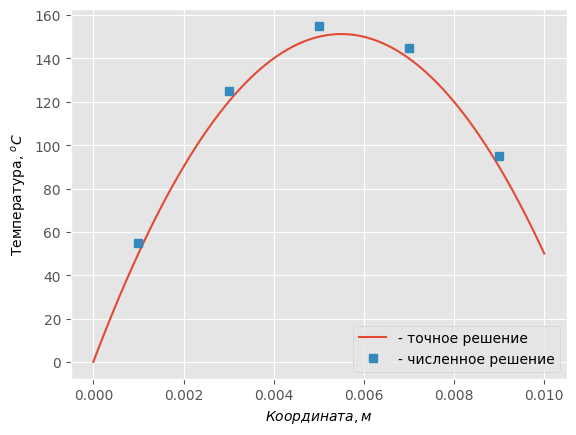

In [26]:
#Выводим и сравниваем
plt.plot(x_exact,t_exact,label='- точное решение')
plt.plot(XP,Phi,'s',label='- численное решение')
plt.legend()     # отображаем легенду
plt.xlabel("$Координата, м$") # подписываем ось x
plt.ylabel("Температура, $^oC$") # подписываем ось y
plt.show()        # отображаем график

Соберем все части программы, описанной в файле "Пример программы для решения одномерного уравнения диффузии" в одну ячейку. Цель - показать цельную программу на языке Python, которая может быть оформлена в виде отдельной программы.

In [27]:
"""
Программа решения одномерного уравнения диффузии.
Свойства постоянны и однородны.
Граничные условия: первого рода  на обоих концах РО.
"""
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def TDMA(A,b):
    ne = np.size(b) # количество уравнений
    P = np.zeros(ne)
    Q = np.zeros(ne)
    x = np.zeros(ne)
    P[0] = -A[0,1]/A[0,0]
    Q[0] = b[0]/A[0,0]
    #прямая прогонка
    for it in range(1,ne-1):
        P[it] = -A[it,it+1]/(A[it,it]+A[it,it-1]*P[it-1])
        Q[it] = (b[it] - A[it,it-1]*Q[it-1])/(A[it,it]+A[it,it-1]*P[it-1])
    Q[ne-1] = (b[ne-1] - A[ne-1,ne-2]*Q[ne-2])/(A[ne-1,ne-1]+A[ne-1,ne-2]*P[ne-2])
    #обратная прогонка
    x[ne-1] = Q[ne-1]
    for it in range(ne-2, -1, -1):
        x[it] = P[it]*x[it+1] + Q[it]
    return x

def Solve1D(Lx,Nx,GammaFun,AreaFun,CSourceFun,VSourceFun,PhiA,PhiB,Tol=1.0e-6):
    #I. создание сетки и определение геометрических параметров
    
    #грани КО
    XFace = np.linspace(0.0,Lx,Nx+1)
    #Ширина КО
    DX = XFace[1:Nx+1] - XFace[0:Nx]
    #Площади граней
    AFace = np.zeros(Nx+1)
    AFace[:] = AreaFun(XFace[:])
    #Создаем массив XP с размером Nx и инициализируем его нулевыми значениями .  
    XP = np.zeros(Nx)  
    XP = (XFace[0:Nx] + XFace[1:Nx+1])/2.0
    #объемы КО
    VolumeP = np.zeros(Nx)
    VolumeP[:] = DX[0:Nx]*(AFace[0:Nx] + AFace[1:Nx+1])/2.0
    
    #Объявление массивов
    Phi = np.zeros_like(XP,dtype=float)
    PhiOld = np.zeros_like(XP,dtype=float)
    Gamma = np.zeros(Nx,dtype=float)
    AlphaX = np.zeros(Nx,dtype=float)
    A = np.zeros((Nx,Nx),dtype=float)
    b = np.zeros(Nx,dtype=float)
    
    #итерации, они нужы если коэффициент диффузии или источник зависят от неизвестной величины
    err = 1.0
    ISweep = 0.0
    while err > Tol:
        PhiOld = Phi.copy()
        for i in range(0,Nx):
            Gamma[i] = GammaFun(XP[i],Phi[i])
        AlphaX[:] = 2.0*Gamma[:]/DX[:]
        
        #заполнений матрицы A и столбца b
        A[:,:] = 0.0
        b[:] = 0.0
        for i in range(0,Nx):
            if i != Nx - 1:    
                anb = AlphaX[i]*AlphaX[i+1]/(AlphaX[i]+AlphaX[i+1])*AFace[i+1]
                A[i,i] += anb
                A[i+1,i+1] += anb
                A[i+1,i] -= anb
                A[i,i+1] -= anb
            CVal, SVal =  CSourceFun(XP[i], Phi[i]), VSourceFun(XP[i], Phi[i])
            b[i] += CVal*SVal*VolumeP[i]
            A[i,i] += CVal*VolumeP[i]
            if i == 0:
                A[0,0] += AlphaX[0]*AFace[0]
                b[0] += AlphaX[0]*AFace[0]*PhiA
            if i == Nx-1:
                A[Nx-1,Nx-1] += AlphaX[Nx-1]*AFace[Nx]
                b[Nx-1] += AlphaX[Nx-1]*AFace[Nx]*PhiB
        Phi = TDMA(A,b)
        err = np.max(np.abs(Phi - PhiOld))
        ISweep += 1
    return XP, Phi, ISweep, XFace, Gamma

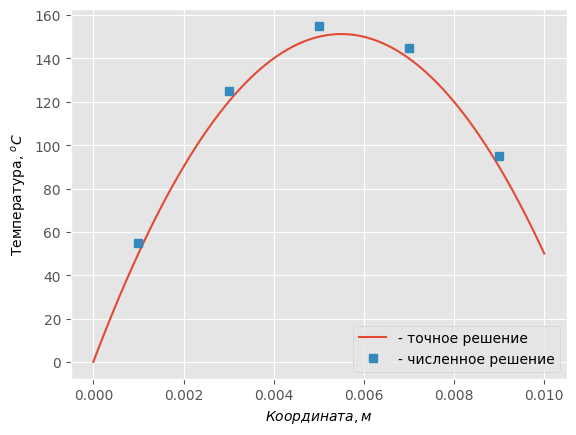

In [28]:
#Параметры
Lx = 0.01 #длина расчетной области
Nx = 5 #количество контрольных объемов
dx = Lx/Nx  #расстояние между центрами контрольных объемов
Area = 1.0 #Площадь всех граней
Lambda = 0.1 #теплопроводность Вт/(м*К)
qv = 1.0e6    #внутреннее тепловыделение Вт/м^3
TA = 0.0 #температура слева
TB = 50.0 #температура справа

def calcArea(x):
    return 1.0
def calcGamma(XP,PhiP):
    return Lambda
def calcCSource(XP,PhiP):
    return 1.0e-20
def calcVSource(XP,PhiP):
    return qv/1.0e-20

#Решение
x,T, ISweep, _, LamdaField = Solve1D(Lx,Nx,calcGamma,calcArea,calcCSource,calcVSource,TA,TB)

#Сравнение с точным решением
def fun_T_exact(x):
    """
    Функция возвращает точное решение
    """
    retVal = TA
    retVal += (TB-TA)*x/Lx
    retVal += qv*x*(Lx-x)/2/Lambda
    return retVal
#Считаем точное решение
x_exact = np.linspace(0.0,Lx,101)
t_exact = fun_T_exact(x_exact)
#Выводим и сравниваем
plt.plot(x_exact,t_exact,label='- точное решение')
plt.plot(x,T,'s',label='- численное решение')
plt.legend()     # отображаем легенду
plt.xlabel("$Координата, м$") # подписываем ось x
plt.ylabel("Температура, $^oC$") # подписываем ось y
plt.show()        # отображаем график

Итоговая версия программы и результаты ее тестирования в файле KM2_Itog_PartII.ipynb